# Machine learning with many-body tensor networks

This notebook examines numerically applying tensor networks on many-body quantum physics in a machine learning sense.

In [19]:
import numpy as np
import pandas as pd
import qiskit

from matplotlib import pyplot as plt
# import torch

# os.environ["CUDA_PATH"] = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.6"
backend = 'jax'
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

# use matplotlib rc style
# plt.style.use('niko.mplstyle')

In [20]:
# %config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn

In [21]:
# n = 5
# depth = 4

# circ = qtn.Circuit(n)

# for r in range(depth):
#     for i in range(circ.N):
#         params = qu.randn(3, dist='uniform') # initialize with random parameters
#         circ.apply_gate('U3', *params, i, gate_round=r, parametrize=True)

#     regs = range(0, circ.N - 1)
#     if r % 2 == 0:
#         regs = reversed(regs)

#     for i in regs:
#         circ.apply_gate('CZ', i, i + 1, gate_round=r)

# # final single qubit layer
# for i in range(circ.N):
#     params = qu.randn(3, dist='uniform') # initialize with random parameters
#     circ.apply_gate('U3', *params, i, gate_round=r, parametrize=True)

In [22]:
def single_qubit_layer(circ, gate_round=None):
    """Apply a parametrizable layer of single qubit ``U3`` gates.
    """
    for i in range(circ.N):
        # initialize with random parameters
        params = qu.randn(3, dist='uniform')
        circ.apply_gate(
            'U3', *params, i,
            gate_round=gate_round, parametrize=True)


def two_qubit_layer(circ, gate2='CZ', reverse=False, gate_round=None):
    """Apply a layer of constant entangling gates.
    """
    regs = range(0, circ.N - 1)
    if reverse:
        regs = reversed(regs)

    for i in regs:
        circ.apply_gate(
            gate2, i, i + 1, gate_round=gate_round)


def ansatz_circuit(n, depth, gate2='CZ', **kwargs):
    """Construct a circuit of single qubit and entangling layers.
    """
    circ = qtn.Circuit(n, **kwargs)

    for r in range(depth):
        # single qubit gate layer
        single_qubit_layer(circ, gate_round=r)

        # alternate between forward and backward CZ layers
        two_qubit_layer(
            circ, gate2=gate2, gate_round=r, reverse=r % 2 == 0)

    # add a final single qubit layer
    single_qubit_layer(circ, gate_round=r + 1)

    return circ

In [58]:
n = 5
depth = 4
gate2 = 'CZ'

circ = ansatz_circuit(n, depth, gate2=gate2)
circ

<Circuit(n=5, num_gates=41, gate_opts={'contract': 'auto-split-gate', 'propagate_tags': 'register'})>

In [59]:
V = circ.uni

/home/nikosavola/.local/lib/python3.9/site-packages/quimb/tensor/circuit.py:1078: FutureWarning: In future the tensor network returned by ``circ.uni`` will not be transposed as it is currently, to match the expectation from ``U = circ.uni.to_dense()`` behaving like ``U @ psi``. You can retain this behaviour with ``circ.get_uni(transposed=True)``.
  warnings.warn(


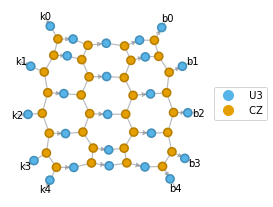

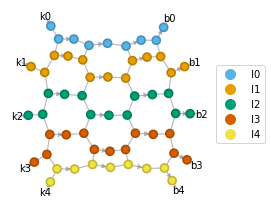

In [61]:
# types of gate
visual_settings = {
    'node_scale': 1.1,
    'arrow_closeness': 1,
    'arrow_length': 4,
    'edge_scale': 1.2,
}

fig = V.draw(color=['U3', gate2], show_inds=True, return_fig=True, **visual_settings)
fig.set_size_inches(3.6, 2.8)
# fig.savefig('../figures/tensor_network_graph.pdf')

fig = V.draw(color=[f'I{i}' for i in range(n)], show_inds=True, return_fig=True, **visual_settings)
fig.set_size_inches(3.6, 2.8)
# fig.savefig('../figures/tensor_network_qubits.pdf')

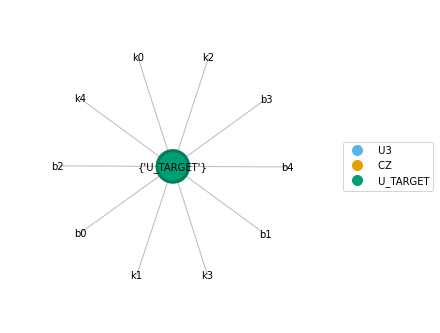

In [7]:
# the hamiltonian
H = qu.ham_ising(n, jz=1.0, bx=0.7, cyclic=False)

# the propagator for the hamiltonian
t = 2
U_dense = qu.expm(-1j * t * H)

# 'tensorized' version of the unitary propagator
U = qtn.Tensor(
    data=U_dense.reshape([2] * (2 * n)),
    inds=[f'k{i}' for i in range(n)] + [f'b{i}' for i in range(n)],
    tags={'U_TARGET'}
)
U.draw(color=['U3', gate2, 'U_TARGET'])

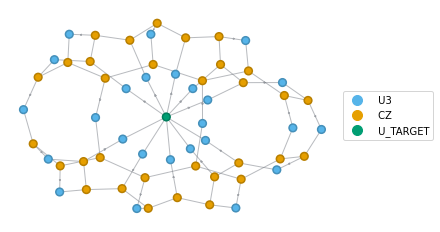

In [8]:
(V.H & U).draw(color=['U3', gate2, 'U_TARGET'])

In [9]:
def loss(V, U):
    return 1 - abs((V.H & U).contract(all, optimize='auto-hq')) / 2**n

# check our current unitary 'infidelity':
loss(V, U)

0.9838068939008755

In [10]:
tnopt = qtn.TNOptimizer(
    V,                        # the tensor network we want to optimize
    loss,                     # the function we want to minimize
    loss_constants={'U': U},  # supply U to the loss function as a constant TN
    tags=['U3'],              # only optimize U3 tensors
    autodiff_backend='jax',   # use 'autograd' for non-compiled optimization
    optimizer='L-BFGS-B',     # the optimization algorithm
)

In [11]:
# allow 10 hops with 500 steps in each 'basin'
V_opt = tnopt.optimize_basinhopping(n=500, nhop=10)

+0.009810626507 [best: +0.009785592556] :  17%|█▋        | 850/5000 [00:11<00:57, 72.51it/s] 


In [12]:
V_opt['U3', 'ROUND_1', 'I2'].params

array([-0.00587951,  1.9637868 ,  0.5875818 ], dtype=float32)

In [13]:
# V_opt.draw(color=['U3', gate2, 'U_TARGET'])

In [14]:
# example generated gates
qu.U_gate(*V_opt['U3', 'ROUND_1', 'I3'].params)

[[ 0.770399+0.j        0.637375-0.01545j ]
 [-0.186259-0.609749j  0.242855+0.73112j ]]

### Test fidelity

In [15]:
V_opt_dense = V_opt.to_dense([f'k{i}' for i in range(n)], [f'b{i}' for i in range(n)])

# random initial state
psi0 = qu.rand_ket(2**n)

# this is the exact state we want
psif_exact = U_dense @ psi0

# this is the state our circuit will produce if fed `psi0`
psif_apprx = V_opt_dense @ psi0

f"Fidelity: {100 * qu.fidelity(psif_apprx, psif_exact):.2f} %"

'Fidelity: 98.93 %'

### Extracting new circuit

In [16]:
circ.update_params_from(V_opt)

# the basic gate specification
# circ.gates

('U3', 0.8614744, 0.76951116, 2.01033, 0)
('U3', -0.8791623, 1.5262035, -1.5721517, 1)
('U3', 0.76359516, 1.3989333, -1.570614, 2)
('U3', 2.2627828, 0.023638632, -1.5717497, 3)
('U3', -2.3072348, 0.6043638, 1.2723361, 4)
('CZ', 3, 4)
('CZ', 2, 3)
('CZ', 1, 2)
('CZ', 0, 1)
('U3', -1.363485, 0.65644133, 0.5038171, 0)
('U3', -1.3876826, 1.6243715, 1.6163532, 1)
('U3', -0.005879507, 1.9637868, 0.5875818, 2)
('U3', -1.38266, 1.2743299, -0.024235027, 3)
('U3', 1.7780032, 1.2108324, 0.76304954, 4)
('CZ', 0, 1)
('CZ', 1, 2)
('CZ', 2, 3)
('CZ', 3, 4)
('U3', 2.2959223, 1.1460946, 0.9423985, 0)
('U3', 0.8458199, -0.24180636, 1.5172741, 1)
('U3', -0.004779379, 1.2471776, 1.8181281, 2)
('U3', 0.84590733, 1.61903, 1.8672808, 3)
('U3', 0.8465862, 1.0285747, 0.34155104, 4)
('CZ', 3, 4)
('CZ', 2, 3)
('CZ', 1, 2)
('CZ', 0, 1)
('U3', 1.3633504, 0.97634923, 0.3970968, 0)
('U3', 1.3877571, 0.22523282, 0.24181387, 1)
('U3', 0.013218991, -0.082113706, -0.30196542, 2)
('U3', 1.3827393, -0.20524907, 1.5225713,

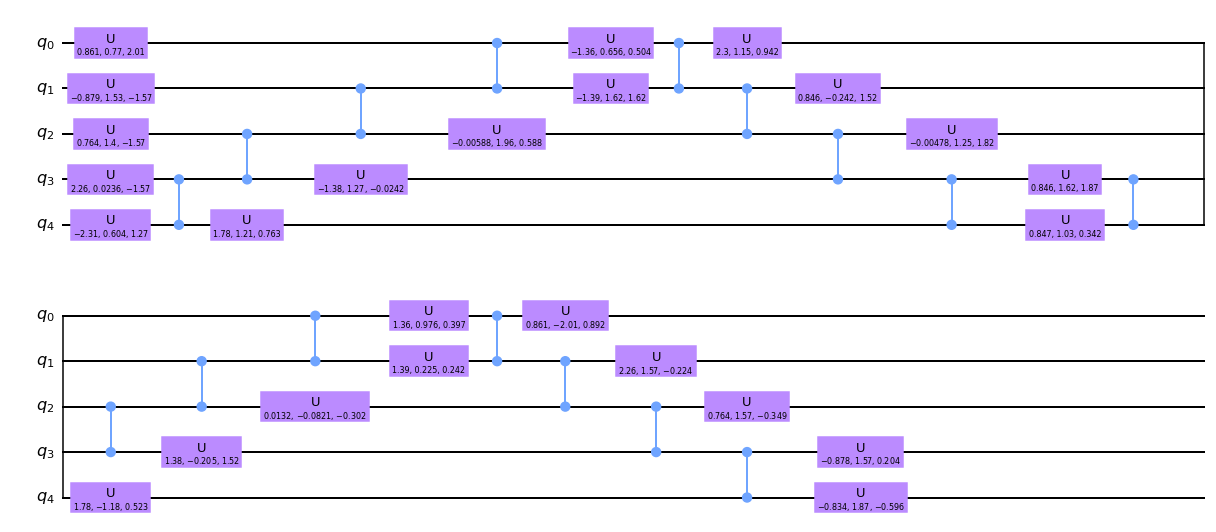

In [17]:
qc = qiskit.QuantumCircuit(n)

for g in circ.gates:
    name, *params = g
    print(g)
    if name == 'U3':
        qc.u(*params)
    elif name == 'CZ':
        qc.cz(*params)

fig = qc.draw('mpl', style="default", initial_state=False, idle_wires=False)#, fold=64)
# fig.savefig('../figures/ansatz_circuit.pdf')
# Fix Qiskit not showing plot
managed_fig = plt.figure()
canvas_manager = managed_fig.canvas.manager
canvas_manager.canvas.figure = fig
fig.set_canvas(canvas_manager.canvas)

In [18]:
# latex_src = qc.draw('latex_source', style="iqx", initial_state=True)
# print(latex_src)